In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import os
from processingmm import batch_processing
from histopolalign import combine_images, prepare_images, semi_automatic_tool, align_folders, match_skeletons, align_imgs, finalize_mask, get_numerical_results

# 1. Process the measurements that will be aligned

In [2]:
# get the folder in which the polarimetric measurements are stored
neoplastic_polarimetry_path = os.path.join(os.getcwd().split('notebooks')[0], 'data', 'TumorMeasurements')
neoplastic_folder = '63'
polarimetry_path = os.path.join(neoplastic_polarimetry_path, neoplastic_folder)
directories = [os.path.join(neoplastic_polarimetry_path, neoplastic_folder)]

In [3]:
# process the measurements, if needed
calib_directory = os.path.join(os.getcwd().split('notebooks')[0], 'calib')
batch_processing.batch_process(directories, calib_directory, run_all = False)

0it [00:00, ?it/s]


[]

# 2. Get the combined masks for the histology folders

In [4]:
# create the folde that will be used to align pathology and polarimetry
combine_images.create_to_align_folder()

# load the pathology images...
histology_path = os.path.join(os.getcwd().split('notebooks')[0], 'data', 'HistologyResults')
imgs_all = combine_images.load_the_images(histology_path, Verbose = True)

# ...and process them
combine_images.get_combined_img(imgs_all, force_recompute = True, Verbose = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.98it/s]


Load the images: 1.798 seconds.
Get combined images: 0.612 seconds.


# 3. Obtain the parameters (manually using the GUI) to first align the histology and the polarimetry

### 3.1. Prepare the images

In [5]:
alignment_measurements = prepare_images.create_the_alignments(histology_path, polarimetry_path, Verbose = True)
alignment_measurements

Get polarimetry filenames and rename images: 0.000 seconds.
Create the alignment objects: 0.000 seconds.


[Folder path: C:\Users\romai\Documents\PathologyPaper\data\TumorMeasurements\63\2022-11-08_T_HORAO-63-BF_FR_S1_1, histology path : C:\Users\romai\Documents\PathologyPaper\data\HistologyResults\63\HORAO-63-S1-1,  status: initialized,
 Folder path: C:\Users\romai\Documents\PathologyPaper\data\TumorMeasurements\63\2022-11-08_T_HORAO-63-BF_FR_S2_1, histology path : C:\Users\romai\Documents\PathologyPaper\data\HistologyResults\63\HORAO-63-S2-1,  status: initialized,
 Folder path: C:\Users\romai\Documents\PathologyPaper\data\TumorMeasurements\63\2022-11-28_T_HORAO-63-AF_FR_S1_1, histology path : C:\Users\romai\Documents\PathologyPaper\data\HistologyResults\63\HORAO-63-S1-20,  status: initialized,
 Folder path: C:\Users\romai\Documents\PathologyPaper\data\TumorMeasurements\63\2022-11-28_T_HORAO-63-AF_FR_S2_1, histology path : C:\Users\romai\Documents\PathologyPaper\data\HistologyResults\63\HORAO-63-S2-20,  status: initialized,
 Folder path: C:\Users\romai\Documents\PathologyPaper\data\TumorMe

### 3.2. Load the polarimetry, labels and histology (H&E) images for each polarimetry folder

In [6]:
alignment_measurements = prepare_images.load_and_preprocess_imgs(alignment_measurements, force_recompute = False, Verbose = True)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Get the images and center of mass: 0.020 seconds.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:00,  4.47it/s]

Load the images: 0.204 seconds.
Get the images and center of mass: 0.006 seconds.


 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:00,  4.67it/s]

Load the images: 0.186 seconds.
Get the images and center of mass: 0.004 seconds.


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:00<00:00,  4.89it/s]

Load the images: 0.232 seconds.
Get the images and center of mass: 0.006 seconds.
Load the images: 0.167 seconds.
Get the images and center of mass: 0.008 seconds.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.66it/s]

Load the images: 0.223 seconds.


### 3.3. Semi-automatic rotation/alignement tool

In [7]:
for measurement in alignment_measurements:
    selector = semi_automatic_tool.ask_for_parameters(measurement, force_recompute = False)

# 4. Actually perform the alignment

In [8]:
align_folders.create_align_folders(alignment_measurements, Verbose = True)

 20%|████████████████▊                                                                   | 1/5 [00:00<00:01,  2.47it/s]

Process the images to apply the selected changes: 0.278 seconds.
Save the processed images: 0.016 seconds.


 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:01,  2.58it/s]

Process the images to apply the selected changes: 0.249 seconds.
Save the processed images: 0.031 seconds.


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:01<00:00,  2.47it/s]

Process the images to apply the selected changes: 0.286 seconds.
Save the processed images: 0.037 seconds.


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:01<00:00,  2.57it/s]

Process the images to apply the selected changes: 0.253 seconds.
Save the processed images: 0.031 seconds.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s]

Process the images to apply the selected changes: 0.249 seconds.
Save the processed images: 0.015 seconds.


### 4.1. Automatic part

In [9]:
border_parameter = 5
nsamples = 400
max_distance = 150

for measurement in tqdm(alignment_measurements):
    match_skeletons.match_skeletons(measurement, border_parameter, nsamples = nsamples, max_distance = max_distance,
                                                                   Verbose = True)

 20%|████████████████▊                                                                   | 1/5 [00:15<01:00, 15.17s/it]

Match the two skeletons: 15.168 seconds.


 40%|█████████████████████████████████▌                                                  | 2/5 [00:30<00:45, 15.03s/it]

Match the two skeletons: 14.925 seconds.


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:43<00:28, 14.35s/it]

Match the two skeletons: 13.525 seconds.


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:56<00:13, 13.86s/it]

Match the two skeletons: 13.122 seconds.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 14.00s/it]

Match the two skeletons: 13.211 seconds.


### 4.2. Semi-automatic part

In [10]:
align_folders.semi_automatic_processing(alignment_measurements)

In [11]:
alignment_measurements = align_imgs.align_img_master(alignment_measurements)

### 4.3. Get the final masks and overlay them on the polarimetric parameter maps

In [12]:
finalize_mask.generate_final_masks(alignment_measurements, Verbose = False)

### 4.4. Finalize and save the numerical results

In [13]:
values = get_numerical_results.create_numerical_values(alignment_measurements)

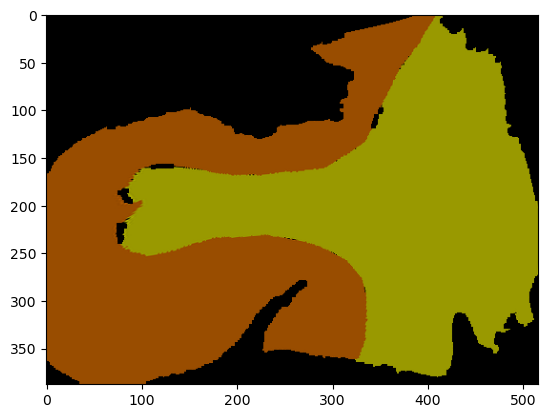

In [18]:
import matplotlib.pyplot as plt
plt.imshow(alignment_measurements[0].labels_GM_WM_aligned_blobed)